In [2]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%aimport std_func

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import string
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

## Estimates from Factor Model

In [3]:
r_selected = pd.read_csv("filtered_r.csv")
# get the mean of all 
r_selected.set_index("name", inplace = True)
mu = r_selected.mean(axis = 1)
# compute the covariance matrix 
cov = r_selected.T.cov()

In [18]:
df = pd.read_csv('../data/preprocessed.csv',
                 usecols = ['reportingDate', 'name', 'CIK', 'coDescription',
                           'coDescription_stopwords', 'SIC', 'SIC_desc'])
df = df.set_index(df.name)

### Sent-LDA
We ran the coherence score benchmarking over a range of 3 to 40 topics, incrementing by 3. First, we fit the LDA model to all business description using the number of topics selected from coherence score benchmarking. Then, we assume each sentence only represents one topic; get the frequency of the topics revealed in the whole document (business description for one company) and calculate the probability of each topics in the whole document. 

In [5]:
data = df.loc[:,"coDescription_stopwords"].to_list()
len(data)

675

In [30]:
def get_topics(model, vectorizer, num_topics):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names_out()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-10 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [7]:
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, TfidfModel

dictionary = Dictionary(doc.split() for doc in data)
 # filter out too in/frequent tokens
dictionary.filter_extremes(no_below=0.01, no_above=0.85, keep_n = 5000)

corpus = [dictionary.doc2bow(doc.split()) for doc in data]
# create list of topic number we want to try 
topic_nums = list(np.arange(3, 40,3))

coherence_scores = []
for num in topic_nums:
    lda = LdaModel(corpus=corpus,
    num_topics=num,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0.01,
    random_state=0)
    
    
    cm = CoherenceModel(
    model=lda,
    texts=[doc.split() for doc in data],
    dictionary=dictionary,
    coherence="c_v")

    coherence_scores.append(round(cm.get_coherence(),5))

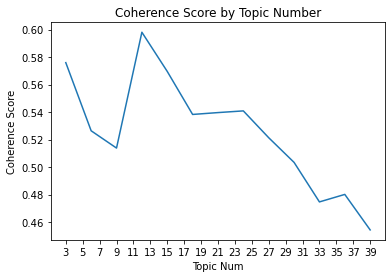

In [8]:
scores = list(zip(topic_nums, coherence_scores))
plt.plot(topic_nums, coherence_scores)
plt.xticks(np.arange(3, 40,2))
plt.ylabel('Coherence Score')
plt.xlabel('Topic Num')
plt.title("Coherence Score by Topic Number")
plt.show()

Based on the above Coherence Score, we choose up to 12 topics since it gives the highest score up to here.

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.85, min_df=2, max_features=600)
tf = tf_vectorizer.fit_transform(data)
tf_feature_names = tf_vectorizer.get_feature_names_out()
lda = LatentDirichletAllocation(n_components=12, random_state=0).fit(tf)

We show the top 10 words by weights in the 12 topics LDA model generates in the below table.

In [33]:
get_topics(lda, tf_vectorizer, 12)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12
0,could,loan,share,product,investment,gas,hotel,patient,bank,customer,million,cell
1,gas,mortgage,stock,drug,income,oil,facility,treatment,capital,service,tax,cancer
2,regulation,real,note,fda,asset,natural,tenant,trial,institution,data,asset,tumor
3,oil,estate,issued,clinical,reit,production,lease,study,federal,product,net,product
4,future,commercial,preferred,patent,real,reserve,operating,phase,act,solution,income,therapy
5,natural,bank,date,approval,tax,proved,estate,clinical,banking,software,cash,therapeutic
6,price,interest,amount,trial,share,drilling,million,disease,holding,platform,expense,clinical
7,affect,rate,september,application,interest,regulation,real,drug,regulation,technology,value,technology
8,ability,million,per,regulatory,distribution,net,center,therapy,deposit,application,note,research
9,adversely,security,director,candidate,estate,water,portfolio,data,asset,sale,statement,license


#### Assign Frequency of the topic to each sentence

In [48]:
n_components = 12
prob = pd.DataFrame(0, index = df.name, columns = range(n_components))

In [49]:
for j in range(len(df)):
    LIST_sent = pd.Series(df.coDescription[j].split('.')).apply(std_func.lemmatize_sentence).apply(std_func.remove_nums).apply(std_func.remove_stopwords)
    
    X = tf_vectorizer.transform(LIST_sent.tolist())
    sent = lda.transform(X)
    sent_df = pd.DataFrame(sent)
    # drop the values that are smaller than 1/12
    # if the maximum value is 1/12, the probability of each topic in that sentence is the same
    # we cannot determine which topic to choose
    sent_df = sent_df[sent_df.max(axis = 1) > 1/12].reset_index(drop = True)

    for i in range(n_components):
        prob.iloc[j][i] = list(sent_df.idxmax(axis = 1)).count(i)
    
    # calculate the probability
    prob = prob.div(prob.sum(axis=1), axis=0)

In [57]:
prob

,0,1,2,3,4,5,6,7,8,9,10,11
name,,,,,,,,,,,,
"MONGODB, INC.",0.014652,0.007326,0.021978,0.036630,0.018315,0.010989,0.040293,0.021978,0.014652,0.739927,0.047619,0.025641
SALESFORCE COM INC,0.010811,0.010811,0.005405,0.016216,0.000000,0.021622,0.037838,0.005405,0.005405,0.821622,0.054054,0.010811
SPLUNK INC,0.010274,0.003425,0.013699,0.020548,0.013699,0.003425,0.023973,0.000000,0.003425,0.839041,0.058219,0.010274
"OKTA, INC.",0.020305,0.000000,0.015228,0.050761,0.015228,0.005076,0.040609,0.000000,0.015228,0.786802,0.030457,0.020305
VEEVA SYSTEMS INC,0.093245,0.012845,0.094196,0.028544,0.035205,0.008563,0.019981,0.010466,0.017602,0.315414,0.352046,0.011893
...,...,...,...,...,...,...,...,...,...,...,...,...
"AMERICAN REALTY CAPITAL NEW YORK CITY REIT, INC.",0.075472,0.084906,0.122642,0.009434,0.471698,0.009434,0.075472,0.000000,0.000000,0.066038,0.084906,0.000000
"CYCLACEL PHARMACEUTICALS, INC.",0.027460,0.000000,0.029748,0.272311,0.011442,0.009153,0.018307,0.308924,0.000000,0.029748,0.013730,0.279176
ZOETIS INC.,0.036519,0.018868,0.074254,0.033475,0.034084,0.013999,0.035301,0.018868,0.020694,0.053561,0.644553,0.015825


In [43]:
# get the names of the companies in the pharmaceutical preparations industry
Pharm = df[df.SIC == 2834]
Pharm_list = Pharm.index

In [44]:
# get the companies name that match return data and business description data
SET = (set(Pharm_list) & set(r_selected.index))
LIST = [*SET, ]

In [60]:
B_matrix = prob.T[LIST].T.drop_duplicates()
B_matrix

,0,1,2,3,4,5,6,7,8,9,10,11
name,,,,,,,,,,,,
ADAMIS PHARMACEUTICALS CORP,0.090551,0.001969,0.013780,0.580709,0.009843,0.009843,0.021654,0.108268,0.019685,0.074803,0.019685,0.049213
STRONGBRIDGE BIOPHARMA PLC,0.036936,0.006840,0.030096,0.331053,0.008208,0.008208,0.020520,0.425445,0.021888,0.035568,0.023256,0.051984
"BELLEROPHON THERAPEUTICS, INC.",0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.125000
"PTC THERAPEUTICS, INC.",0.034934,0.004367,0.008734,0.262009,0.004367,0.008734,0.008734,0.432314,0.008734,0.021834,0.078603,0.126638
"PULMATRIX, INC.",0.030303,0.006061,0.009091,0.439394,0.009091,0.006061,0.021212,0.336364,0.009091,0.042424,0.015152,0.075758
...,...,...,...,...,...,...,...,...,...,...,...,...
"ALNYLAM PHARMACEUTICALS, INC.",0.021967,0.004184,0.038703,0.401674,0.017782,0.011506,0.009414,0.244770,0.016736,0.047071,0.012552,0.173640
REGENERON PHARMACEUTICALS INC,0.034420,0.009058,0.054348,0.329710,0.016304,0.016304,0.028986,0.175725,0.016304,0.047101,0.083333,0.188406
AXOVANT SCIENCES LTD.,0.000000,0.000000,0.000000,0.020833,0.000000,0.062500,0.020833,0.687500,0.000000,0.000000,0.000000,0.208333


In [55]:
r_Pharm = r_selected.T[LIST].T
r_Pharm

,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,...,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31
name,,,,,,,,,,,,,,,,,,,,,
ADAMIS PHARMACEUTICALS CORP,-0.677047,0.003571,0.049822,0.162712,-0.249271,0.087379,0.125000,-0.015873,0.112903,0.231884,...,0.166667,0.028571,0.194444,-0.255814,0.000000,-0.109375,0.228070,-0.268571,0.191406,-0.262295
STRONGBRIDGE BIOPHARMA PLC,-0.179381,0.080402,0.106977,0.096639,-0.157088,-0.136364,-0.368421,0.020833,0.204082,0.610169,...,0.212329,-0.135593,-0.150327,-0.076923,-0.208333,0.157895,-0.118182,0.319588,-0.184375,-0.141762
"BELLEROPHON THERAPEUTICS, INC.",0.404762,-0.084746,-0.059568,-0.081063,-0.164286,-0.598291,0.106809,0.249519,1.138462,0.071942,...,0.077720,0.105769,-0.039130,0.095023,0.033058,-0.654000,0.248555,-0.275278,0.213747,-0.156421
"PTC THERAPEUTICS, INC.",-0.139706,-0.149573,0.375209,0.706456,-0.556745,0.793881,-0.020646,0.200733,0.040458,-0.278063,...,0.050874,0.024760,0.222503,-0.005015,0.128669,0.096401,0.126018,-0.180426,-0.077882,-0.033784
"PULMATRIX, INC.",-0.190083,0.081633,-0.275142,0.073729,-0.224242,-0.531250,-0.016667,2.644068,0.906977,-0.148780,...,-0.636429,-0.111198,0.048187,-0.051033,0.022222,-0.043478,-0.159091,0.011892,-0.020833,-0.345063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"ALNYLAM PHARMACEUTICALS, INC.",-0.226297,0.226888,0.025999,-0.029635,-0.474771,0.232303,-0.146569,0.068109,0.291323,-0.007552,...,-0.008822,-0.206297,0.052259,-0.009852,-0.035435,0.291263,-0.286541,-0.081010,0.009076,-0.101651
REGENERON PHARMACEUTICALS INC,-0.124583,0.217307,-0.076614,0.024124,-0.141784,0.099183,-0.032038,-0.021248,0.039550,0.037510,...,0.074647,-0.118132,-0.011064,0.148741,0.066727,0.105269,-0.006663,-0.160380,0.077850,0.021469
AXOVANT SCIENCES LTD.,-0.028009,0.152648,0.108784,-0.146862,-0.120714,0.099106,-0.082040,-0.013688,0.037551,0.175452,...,-0.076389,-0.195489,0.579439,0.337278,-0.057522,0.173709,-0.032000,-0.227273,-0.032086,-0.449724


In [64]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
for i in range(len(r_Pharm.columns)):
    date = r_Pharm.columns[i]
    r_t_i = r_Pharm[date] 
    reg = LinearRegression().fit(B_matrix, r_t_i)
    #print(reg.score(B_matrix, r_t_i))
    print(reg.coef_)

[-1.87101436e+13 -1.87101436e+13 -1.87101436e+13 -1.87101436e+13
 -1.87101436e+13 -1.87101436e+13 -1.87101436e+13 -1.87101436e+13
 -1.87101436e+13 -1.87101436e+13 -1.87101436e+13 -1.87101436e+13]
[-2.06980722e+12 -2.06980722e+12 -2.06980722e+12 -2.06980722e+12
 -2.06980722e+12 -2.06980722e+12 -2.06980722e+12 -2.06980722e+12
 -2.06980722e+12 -2.06980722e+12 -2.06980722e+12 -2.06980722e+12]
[3.04677396e+13 3.04677396e+13 3.04677396e+13 3.04677396e+13
 3.04677396e+13 3.04677396e+13 3.04677396e+13 3.04677396e+13
 3.04677396e+13 3.04677396e+13 3.04677396e+13 3.04677396e+13]
[2.52703094e+13 2.52703094e+13 2.52703094e+13 2.52703094e+13
 2.52703094e+13 2.52703094e+13 2.52703094e+13 2.52703094e+13
 2.52703094e+13 2.52703094e+13 2.52703094e+13 2.52703094e+13]
[-9.13764183e+12 -9.13764183e+12 -9.13764183e+12 -9.13764183e+12
 -9.13764183e+12 -9.13764183e+12 -9.13764183e+12 -9.13764183e+12
 -9.13764183e+12 -9.13764183e+12 -9.13764183e+12 -9.13764183e+12]
[5.7977783e+13 5.7977783e+13 5.7977783e+13 5

#### Mean for Returns in the Pharmaceutical Preparations Industry

In [46]:
mu_Pharm = mu[LIST]

### Portfolio Weights on Different Extremes

#### Comparing return mean and covariance

/Users/lulu/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


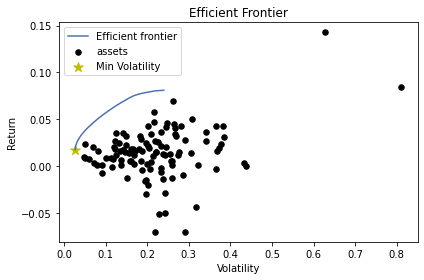

In [19]:
ef1 = EfficientFrontier(mu_Pharm, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_Pharm, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="y", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Returns.png', dpi=200, bbox_inches='tight')
plt.show()

##### min volatility

In [20]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 1.8%
Annual volatility: 2.7%
Sharpe Ratio: -0.08


In [21]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        print(company, weight)

XENCOR INC 0.02028
ATHERSYS, INC / NEW 0.04453
ARENA PHARMACEUTICALS INC 0.03982
LILLY ELI & CO 0.02763
VTV THERAPEUTICS INC. 0.03609
ANI PHARMACEUTICALS INC 0.00444
ACTINIUM PHARMACEUTICALS, INC. 0.00031
MERCK & CO., INC. 0.2
RECRO PHARMA, INC. 0.00826
BRISTOL MYERS SQUIBB CO 0.08558
XENON PHARMACEUTICALS INC. 0.01629
ABBVIE INC. 0.01108
KARYOPHARM THERAPEUTICS INC. 0.00495
ZOETIS INC. 0.2
ASSEMBLY BIOSCIENCES, INC. 0.0271
CATALYST PHARMACEUTICALS, INC. 0.02193
JOHNSON & JOHNSON 0.1571
REGENERON PHARMACEUTICALS INC 0.01155
ORAGENICS INC 0.0061
ACHAOGEN INC 0.01319
PROPHASE LABS, INC. 0.05081
BLUEPRINT MEDICINES CORP 0.01296


In [22]:
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
import dataframe_image as dfi
min_vol.dfi.export('min_vol_returns.png')

[0416/201424.351321:INFO:headless_shell.cc(659)] Written to file /var/folders/6t/0lh6qmkn1zg8fhlp984cpxrr0000gn/T/tmpz3pe4nk9/temp.png.


In [23]:
min_vol

,Company_Name,Weight
0,XENCOR INC,0.02028
1,"ATHERSYS, INC / NEW",0.04453
2,ARENA PHARMACEUTICALS INC,0.03982
3,LILLY ELI & CO,0.02763
4,VTV THERAPEUTICS INC.,0.03609
5,ANI PHARMACEUTICALS INC,0.00444
6,"ACTINIUM PHARMACEUTICALS, INC.",0.00031
7,"MERCK & CO., INC.",0.20000
8,"RECRO PHARMA, INC.",0.00826
9,BRISTOL MYERS SQUIBB CO,0.08558


#### Comparing return mean and covariance from cosine similarity

/Users/lulu/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


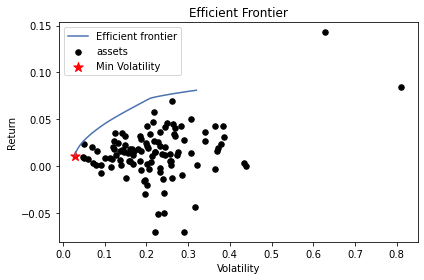

In [24]:
ef1 = EfficientFrontier(mu_Pharm, cos_sim_cov, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_Pharm, cos_sim_cov, weight_bounds=(0, 0.2))
# max sharpe ratio
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Cos_Sim.png', dpi=200, bbox_inches='tight')
plt.show()

##### Min Volatility

In [25]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 1.2%
Annual volatility: 3.0%
Sharpe Ratio: -0.29


In [26]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        print(company, weight)

PACIRA PHARMACEUTICALS, INC. 0.03308
XENCOR INC 0.0433
HERON THERAPEUTICS, INC. /DE/ 0.01409
MERCK & CO., INC. 0.1978
BELLEROPHON THERAPEUTICS, INC. 0.00621
BRISTOL MYERS SQUIBB CO 0.09943
PERRIGO CO PLC 0.0173
PFIZER INC 0.14718
ZOETIS INC. 0.2
JOHNSON & JOHNSON 0.19918
BIOMARIN PHARMACEUTICAL INC 0.04242


In [27]:
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.dfi.export('max_sharpe_cos_sim.png')

[0416/201430.379836:INFO:headless_shell.cc(659)] Written to file /var/folders/6t/0lh6qmkn1zg8fhlp984cpxrr0000gn/T/tmpf0o08ytd/temp.png.


In [28]:
min_vol

,Company_Name,Weight
0,"PACIRA PHARMACEUTICALS, INC.",0.03308
1,XENCOR INC,0.04330
2,"HERON THERAPEUTICS, INC. /DE/",0.01409
3,"MERCK & CO., INC.",0.19780
4,"BELLEROPHON THERAPEUTICS, INC.",0.00621
5,BRISTOL MYERS SQUIBB CO,0.09943
6,PERRIGO CO PLC,0.01730
7,PFIZER INC,0.14718
8,ZOETIS INC.,0.20000
9,JOHNSON & JOHNSON,0.19918
